In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [2]:
import ktrain
from ktrain import graph as gr

Using TensorFlow backend.


using Keras version: 2.2.4


# Node Classification in Graphs

Consider a social network (e.g., Facebook, Linkedin, Twitter) where each node is a person and links represent friendships. Each node (or person) in the graph can be be described by various attributes such as their location, Alma mater, organizational memberships, gender, relationship status, children, etc.  Suppose we had the U.S. political affiliation (e.g., Democrat, Republican, Libertarian, Green Party) of only a small subset of nodes with the remaining nodes being unknown.  Here, node classification involves predicting the political affiliation of unknown nodes based only on the small subset of of nodes for which we know the political affiliation. 

Where as traditional tabular-based models (e.g., logistic regression, SVM) utilize only the node's attributes to predict a node's label, graph neural networks utilize both the node's attributes and the graph's structure. For instance, to predict the political affiliation of a person it is helpful to not only look at the person's attributes but the attributes of other people within the vicinity of this person in the social network. Birds of a feather typically flock together. By exploiting graph structure, graph neural networks require much less labeled ground truth than non-graph approaches.  For instance, in the example below, we will consider the labels of only a very small fraction of all nodes to build our model.

## Hateful Twitter Users
In this notebook, we will use *ktain* to perform node classification on a Twitter graph to predict hateful users. Each Twitter user is described by various attributes related to both their profile and their tweet behavior. Examples include number of tweets and retweets, status length, etc.  

The dataset can be downloaded from [here](https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter/home).

For node classification, *ktrain* requires two files formatted in a specific way:
- a CSV or tab-delimited file containing the links (or edges) in the graph.  Each row containing two node IDs representing an edge.
- A CSV or tab-delimited file describing the attributes and label associated with each node.  The first column is the node ID and the last column should be the label or target (as string labels such as "hate" or "normal").  All other columns should contain numerical features and are assumed to be standardized or transformed as necessary.  If the last column representing the target has missing values, these are treated as a holdout set for which predictions can be made after training the model. The numeric feature columns should not have any missing values.


## Clean and Prepare Data
We must first transform the raw dataset into the file formats described above. We consider two files: `users.edges` which describes the graph structure and `users_neighborhood_anon.csv` which contains each node's label and attributes.   The file `users.edges` is the edge list and is already in the format expected by *ktrain* for the most part.  We must clean and prepare `users_neighborhood_anon.csv` into the format expected by *ktrain*. We will drop unused columns, normalize numeric attributes, re-order/transform the target column `hate` into an interpretable string label, and save the data as a tab-delimited file.

In [3]:
# useful imports
import sklearn
import numpy as np
import pandas as pd

# read in data
data_dir = 'data/hateful-twitter-users/'
users_feat = pd.read_csv(os.path.join(data_dir, 'users_neighborhood_anon.csv'))

# clean the data and drop unused columns
def data_cleaning(feat):
    feat = feat.drop(columns=["hate_neigh", "normal_neigh"])
    # Convert target values in hate column from strings to integers (0,1,2)
    feat['hate'] = np.where(feat['hate']=='hateful', 1, np.where(feat['hate']=='normal', 0, 2))
    # missing information
    number_of_missing = feat.isnull().sum()
    number_of_missing[number_of_missing!=0]
    # Replace NA with 0
    feat.fillna(0, inplace=True)
    # droping info about suspension and deletion as it is should not be use din the predictive model
    feat.drop(feat.columns[feat.columns.str.contains("is_")], axis=1, inplace=True)
    # drop glove features
    feat.drop(feat.columns[feat.columns.str.contains("_glove")], axis=1, inplace=True)
    # drop c_ features
    feat.drop(feat.columns[feat.columns.str.contains("c_")], axis=1, inplace=True)
    # drop sentiment features for now
    feat.drop(feat.columns[feat.columns.str.contains("sentiment")], axis=1, inplace=True)
    # drop hashtag feature
    feat.drop(['hashtags'], axis=1, inplace=True)
    # Drop centrality based measures
    feat.drop(columns=['betweenness', 'eigenvector', 'in_degree', 'out_degree'], inplace=True)
    feat.drop(columns=['created_at'], inplace=True)
    return feat
node_data = data_cleaning(users_feat)

# recode the target column into human-readable string labels
node_data = node_data.replace({'hate': {0:'normal', 1:'hateful', 2:'unknown'}})

# normalize the numeric columns (ignore columns user_id and hate which is label colum)
df_values = node_data.iloc[:, 2:].values
pt = sklearn.preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
df_values_log = pt.fit_transform(df_values)
node_data.iloc[:, 2:] = df_values_log

# drop user_id and use the equivalent index as node ID
node_data.index = node_data.index.map(str)
node_data.drop(columns=['user_id'], inplace=True)

# move target column to last position
cols = list(node_data)
cols.remove('hate')
cols.append('hate')
node_data = node_data.reindex(columns= cols)
node_data.head()

,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,timidity_empath,gain_empath,...,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median,hate
0,1.541150,0.046773,1.104767,1.869391,0.017835,-1.752256,0.164900,0.181173,0.875069,1.130523,...,-0.049013,0.321929,-0.369992,-1.036127,-0.796091,0.047430,0.356495,-1.888186,-1.299249,normal
1,-0.700240,0.772450,-0.526061,-1.434183,0.613187,-0.735320,-0.864337,0.599279,1.610977,-1.203049,...,1.479066,-1.999580,-1.545285,-0.188945,-1.875745,-0.626192,-1.972207,0.160925,-1.512603,unknown
2,-1.077284,-0.127775,0.767345,-0.669050,-0.523882,-0.118440,-1.573040,1.211083,-0.154213,0.932754,...,-0.201320,0.452537,-1.545285,0.637869,0.884530,-0.096918,0.348954,0.698841,0.122176,unknown
3,1.908494,-0.021575,-0.548705,0.078540,0.017835,-0.472125,1.281633,-0.544862,1.259492,-0.456470,...,-1.018822,1.085858,-0.662393,-0.701835,0.088472,-0.626192,-1.254997,-1.576801,-1.311031,unknown
4,-0.778589,0.729918,2.296049,-0.725089,0.700128,-1.488804,-1.573040,-0.969812,0.199834,-1.203049,...,-0.427866,0.638106,-1.545285,1.370832,0.655433,0.955922,-1.914894,0.803553,1.472247,unknown


In [4]:
# save both data files as tab-delimited to be consistent
node_data.to_csv('/tmp/twitter-nodes.tab', sep='\t', header=False)
edge_data = pd.read_csv(data_dir+'/users.edges', header=None, names=['Source', 'Destination'])
edge_data.to_csv('/tmp/twitter-edges.tab', sep='\t', header=False, index=False)

In [5]:
# check to make sure there are no missing values in the non-target columns
node_data[node_data.drop('hate', axis=1).isnull().any(axis=1)].shape[0]

0

### STEP 1: Load and Preprocess Data

Here, we will load the preprocessed dataset.  Of the nodes that are annotated with labels (i.e., hate vs normal), we will use 15% as the training set and 85% as for validation.  For the nodes with no labels (i.e., tagged as 'unknown' in this dataset), we will create `df_holdout` and `G_complete`.  The dataframe `df_holdout` contains the features of those nodes with no labels and `G_complete` is the entire graph including the nodes in `df_holdout` that were held out. 

If `holdout_for_inductive=True`, then features of holdout nodes are **not** visible during training, and the training graph is a subgraph of `G_complete`.  Otherwise, the features (not labels) of the heldout nodes can be exploited during training.  The `holdout_for_inductive=True` paramter is useful for assessing how well your model can make predictions for new nodes added to the graph later using `G_complete` (*inductive inference*). In this case, `holdout_for_inductive=False`, as we would like to use the features of unlabeled nodes to help learn to make accurate predictions.  `G_complete`, then, is identical to the training graph and is not used, as we are only doing *transductive inference*.  See this example notebook to better see the difference between *transductive* and *inductive* inference in graphs.

In [6]:
(train_data, val_data, preproc, 
 df_holdout, G_complete)        = gr.graph_nodes_from_csv('/tmp/twitter-nodes.tab',
                                           '/tmp/twitter-edges.tab',
                                           sample_size=20, 
                                           holdout_pct=None,  # using missing_label_value for holdout
                                           holdout_for_inductive=False,
                                           missing_label_value='unknown',
                                           train_pct=0.15,
                                           sep='\t')

Largest subgraph statistics: 100386 nodes, 2194979 edges
using 95415 nodes with missing target as holdout set
Size of training graph: 100386 nodes
Training nodes: 745
Validation nodes: 4226
Nodes treated as unlabeled for testing/inference: 95415
Holdout node features are visible during training (transductive inference)



The training graph and the dataframe containing features of all nodes in the training graph are both accessible via the `Preprocessor` instance.  Let's look at the class distributions in the training graph. There is class imbalance here that might be addressed by computing class weights and supplying them to the `class_weight` parameter of any `*fit*` method in *ktrain* and Keras.  We will train without doing so here, though.

In [7]:
print("Initial hateful/normal users distribution")
print(preproc.df.target.value_counts())

Initial hateful/normal users distribution
unknown    95415
normal      4427
hateful      544
Name: target, dtype: int64


### STEP 2: Define a Model and Wrap in Learner Object

In [7]:
gr.print_node_classifiers()

graphsage: GraphSAGE:  http://arxiv.org/pdf/1607.01759.pdf


In [8]:
learner = ktrain.get_learner(model=gr.graph_node_classifier('graphsage', train_data), 
                             train_data=train_data, 
                             val_data=val_data, 
                             batch_size=64)

Is Multi-Label? False
done


### STEP 3:  Estimate LR 
Given the small number of batches per epoch, a larger number of epochs is required to estimate the learning rate. We will cap it at 100 here.

In [10]:
learner.lr_find(max_epochs=100)

simulating training for different learning rates... this may take a few moments...
Epoch 1/100
11/11 [==============================] - 1s 129ms/step - loss: 0.6290 - acc: 0.6650
Epoch 2/100
11/11 [==============================] - 1s 106ms/step - loss: 0.6213 - acc: 0.6693
Epoch 3/100
11/11 [==============================] - 1s 106ms/step - loss: 0.6265 - acc: 0.6871
Epoch 4/100
11/11 [==============================] - 1s 105ms/step - loss: 0.6252 - acc: 0.6963
Epoch 5/100
11/11 [==============================] - 1s 108ms/step - loss: 0.6309 - acc: 0.6832
Epoch 6/100
11/11 [==============================] - 1s 104ms/step - loss: 0.6445 - acc: 0.6350
Epoch 7/100
11/11 [==============================] - 1s 109ms/step - loss: 0.6300 - acc: 0.6543
Epoch 8/100
11/11 [==============================] - 1s 109ms/step - loss: 0.6207 - acc: 0.6785
Epoch 9/100
11/11 [==============================] - 1s 98ms/step - loss: 0.6455 - acc: 0.6495
Epoch 10/100
11/11 [==============================] - 

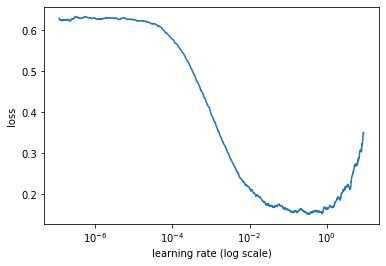

In [11]:
learner.lr_plot()

### STEP 4: Train the Model
We will train the model using `autofit`, which uses a triangular learning rate policy.  We will save the weights for each epoch so that we can reload the best weights when training completes.

In [9]:
learner.autofit(0.005, 30, checkpoint_folder='/tmp/saved_weights')



begin training using triangular learning rate policy with max lr of 0.005...
Epoch 1/30
12/12 [==============================] - 9s 748ms/step - loss: 0.6526 - acc: 0.5750 - val_loss: 0.4119 - val_acc: 0.8907
Epoch 2/30
12/12 [==============================] - 7s 578ms/step - loss: 0.4043 - acc: 0.8889 - val_loss: 0.3422 - val_acc: 0.8907
Epoch 3/30
12/12 [==============================] - 8s 674ms/step - loss: 0.3405 - acc: 0.8889 - val_loss: 0.3063 - val_acc: 0.8907
Epoch 4/30
12/12 [==============================] - 8s 644ms/step - loss: 0.3079 - acc: 0.8889 - val_loss: 0.2740 - val_acc: 0.8907
Epoch 5/30
12/12 [==============================] - 7s 620ms/step - loss: 0.2774 - acc: 0.8889 - val_loss: 0.2527 - val_acc: 0.8907
Epoch 6/30
12/12 [==============================] - 8s 662ms/step - loss: 0.2488 - acc: 0.8902 - val_loss: 0.2311 - val_acc: 0.9193
Epoch 7/30
12/12 [==============================] - 7s 614ms/step - loss: 0.2264 - acc: 0.9118 - val_loss: 0.2206 - val_acc: 0.92

### Evaluate

Let's use the weights from Epoch 12.

In [10]:
learner.model.load_weights('/tmp/saved_weights/weights-12.hdf5')

In [11]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

     hateful       0.68      0.57      0.62       462
      normal       0.95      0.97      0.96      3764

    accuracy                           0.92      4226
   macro avg       0.82      0.77      0.79      4226
weighted avg       0.92      0.92      0.92      4226



array([[ 262,  200],
       [ 122, 3642]])

### Predict

Let's make predictions for all Twitter users that are unlabeled (i.e., we don't know whether or not they are hateful).

In [13]:
p = ktrain.get_predictor(learner.model, preproc)

In [17]:
df_unlabeled = preproc.df[preproc.df.target=='unknown']

In [18]:
preds = p.predict_transductive(df_unlabeled.index)

In [20]:
preds = np.array(preds)

In [31]:
import pandas as pd
df_preds = pd.DataFrame(zip(df_unlabeled.index, preds), columns=['UserID', 'Predicted'])

In [32]:
df_preds[df_preds.Predicted=='hateful'].head()

,UserID,Predicted
52,56,hateful
129,140,hateful
243,259,hateful
475,499,hateful
501,526,hateful


In [34]:
df_preds[df_preds.Predicted=='hateful'].shape[0]

578

Out of over 95,000 unlabeled nodes in the Twitter graph, our model predicted **578** as potential hateful users that would seem to warrant a review.